In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import featuretools as ft
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from random import sample 
import pickle
import eli5
from eli5.sklearn import PermutationImportance
from lightgbm import LGBMClassifier
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline
RSEED = 50

# Load Original Features

In [390]:
feat_num = 447
#df_total = pd.read_csv('./data/features%s_add_card1_cnt.csv'%(feat_num))
with open('./data/features%s.pickle'%(feat_num), 'rb') as handle:
    df_total = pickle.load(handle)

In [391]:
df_train = df_total[df_total['isFraud'].notnull()]
df_train.shape

(590540, 447)

# Negative Downsampling

In [392]:
train_pos = df_train[df_train['isFraud']==1]
train_neg = df_train[df_train['isFraud']==0]

train_neg = train_neg.sample(int(df_train.shape[0] * 0.2), random_state=42)
df_train_sample = pd.concat([train_pos,train_neg]).sort_index()

# Prepare Data

In [393]:
labels_train = df_train_sample['isFraud']
features_train = df_train_sample.drop(columns = ['isFraud', 'TransactionID'])
features_train.shape

(138771, 445)

In [394]:
features_train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,addr1_fq_enc,card_addr_fq,card_mv_hour_fq,card_mv_hour_fq_ratio,card_hour_Amt,card_hour_Amt_ratio,card_mv_day_fq,card_mv_day_fq_ratio,card_day_Amt,card_day_Amt_ratio
2,86469,59.00,0,4663,490.0,150.0,2,166.0,1,330.0,...,48387.0,13.0,1,1.000000,59.00,0.969659,1,1.000000,59.00,0.969659
6,86522,159.00,0,12308,360.0,150.0,2,166.0,1,126.0,...,28198.0,2.0,1,1.000000,159.00,1.338947,1,1.000000,159.00,1.338947
7,86529,422.50,0,12695,490.0,150.0,2,226.0,1,325.0,...,76902.0,221.0,1,0.909465,422.50,3.459943,2,0.975717,466.50,2.003035
12,86564,50.00,0,3786,418.0,150.0,2,226.0,1,204.0,...,77069.0,1.0,1,1.000000,50.00,1.000000,1,1.000000,50.00,1.000000
24,86821,73.95,0,10112,360.0,150.0,2,166.0,1,264.0,...,72580.0,1.0,1,1.000000,73.95,1.000000,1,1.000000,73.95,1.000000


In [395]:
with open('./data/feat%s_rm_pm_importance100.pickle'%(437), 'rb') as handle:
    to_drop = pickle.load(handle)

In [396]:
features_train = features_train.drop(list(to_drop),axis=1)

In [397]:
categorical_raw = ['ProductCD', 'card2', 'card3', 'card4', 'card5','card6',
              'addr1','addr2','P_email','R_email','M1','M2','M3',
              'M4','M5','M6','M7','M8','M9','DeviceType','DeviceInfo','dow','hour',
              'Device_name','Device_version','screen_width','screen_height',
               'P_email_suffix','R_email_suffix','id_30_OS','id_30_version',
               'is_card_freq_Device','is_wide','is_long','is_zero','is_win8_vista',
               'is_windows_otheros','is_card_freq_pdc','is_card_freq_addr1'] #

ids = [ 'id_%s'%(i) for i in range(12,39)]
categorical_raw = categorical_raw + ids

In [398]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
          #'num_threads':10
          #'is_unbalance':True
          #'scale_pos_weight':9
         }

# Select Features

In [9]:
def train_selector(params,train_num,features_train,labels_train,categorical,verbose_eval=500):
    train_set = lgb.Dataset(features_train.iloc[0:train_num,:], label=labels_train.values[0:train_num],
                       categorical_feature=categorical)
    valid_set = lgb.Dataset(features_train.iloc[train_num:,:], label=labels_train.values[train_num:],
                       categorical_feature=categorical)
    valid_results = {}
    model = lgb.train(params,train_set,num_boost_round = 10000, 
                   valid_sets = [train_set, valid_set],
                    verbose_eval= verbose_eval,
                    early_stopping_rounds = 500,
                    evals_result=valid_results)
    return model,valid_results

In [10]:
def select_by_importance(model,features_train,importance=0,num_keep=None):
    fi = pd.DataFrame({'feature': features_train.columns, 
                   'importance':model.feature_importance()})
    fi = fi.sort_values('importance', ascending = False)
    if num_keep != None:
        to_drop = fi.iloc[num_keep:,:].feature
    else:
        to_drop = fi[fi.importance <= importance].feature
    return to_drop
    

In [11]:
def fold_train_selector(Nfold,features_train,labels_train,categorical):
    splits = Nfold
    ave_auc = 0
    valid_results = {}
    
    folds = KFold(n_splits = splits,random_state=RSEED)
    
    for fold_num, (trn_idx, val_idx) in enumerate(folds.split(features_train.values, 
                                                          labels_train.values)):
        print("Fold {}".format(fold_num))
        train_df, y_train_df = features_train.iloc[trn_idx], labels_train.iloc[trn_idx]
        valid_df, y_valid_df = features_train.iloc[val_idx], labels_train.iloc[val_idx]
    
        trn_data = lgb.Dataset(train_df, label=y_train_df,categorical_feature=categorical)
        val_data = lgb.Dataset(valid_df, label=y_valid_df,categorical_feature=categorical)
    
        
        clf = lgb.train(params,
                        trn_data,
                        10000,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=500,
                        early_stopping_rounds=500,
                       evals_result=valid_results)
        

        pred = clf.predict(valid_df)
        auc_score = roc_auc_score(y_valid_df, pred)
        ave_auc += auc_score / splits
        print( "  auc = ", auc_score )
    return ave_auc

In [12]:
def permutation_importance(model,features_valid,labels_valid):
    """calculate permutation importance of features
    Args:
        model: the trained model.
        features_valid: dataframe. The validation set of features.
        labels_valid: labels of validation set.
    Returns:
        df_fimportance: dataframe. The importances of features.
    """
    base_score = roc_auc_score(labels_valid, model.predict(features_valid))
    list_fimportance = []
    for col in features_valid.columns:
        print(col)
        save = features_valid[col].copy()
        features_valid[col] = np.random.permutation(features_valid[col])
        col_score = roc_auc_score(labels_valid, model.predict(features_valid))
        features_valid[col] = save
        list_fimportance.append([col,base_score - col_score])
    return pd.DataFrame(list_fimportance,columns = ['feature','importance']) 
    

## PCA V Features

In [15]:
def check_missing(df,cols=None,axis=0):
    """check data frame column missing situation
    Args
    df: data frame.
    cols: list. List of column names
    axis: int. 0 means column and 1 means row
    
    Returns
    missing_info: data frame. 
    """
    if cols != None:
        df = df[cols]
    missing_num = df.isnull().sum(axis).to_frame().rename(columns={0:'missing_num'})
    missing_num['missing_percent'] = df.isnull().mean(axis)*100
    return missing_num.sort_values(by='missing_percent',ascending = False) 

In [246]:
vfeatures = ['V'+str(i) for i in range(1,340)]

In [228]:
scaler = StandardScaler()
scaler.fit(features_train[vfeatures])
imp = Imputer(missing_values=np.nan , strategy='mean', axis=0)
vfeature_impute = imp.fit_transform(features_train[vfeatures])

/home/jinpwa/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [229]:
vfeature_impute_scale = scaler.transform(vfeature_impute)
vfeature_impute_scale = pd.DataFrame(vfeature_impute_scale, columns=vfeatures)

In [230]:
pca = PCA()
vfeature_pca = pca.fit_transform(vfeature_impute_scale)

In [231]:
# check components number should be the same as total features
components_total = len(pca.explained_variance_ratio_)
# generate sequence for plotting
components = np.arange(components_total)

Text(0.5,1,'Cumulative Explained Variance vs No. of Principal Components')

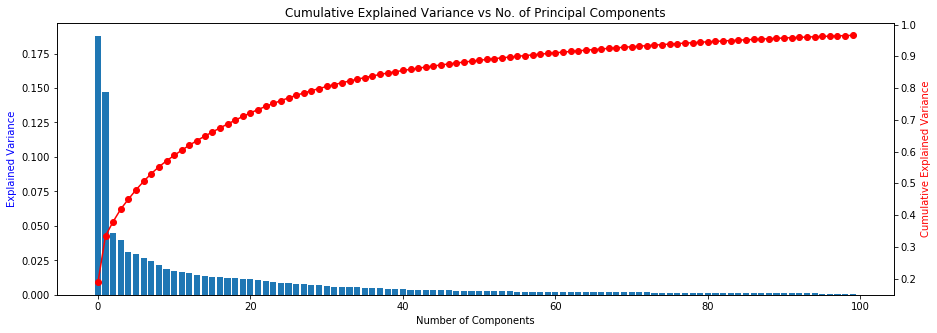

In [232]:
fig, ax1 = plt.subplots(figsize=(15,5))

ax1.bar(components[0:100],pca.explained_variance_ratio_[0:100])
ax1.set_ylabel('Explained Variance', color="blue")
ax1.set_xlabel('Number of Components')

ax2 = ax1.twinx() 
ax2.plot(np.cumsum(pca.explained_variance_ratio_[0:100]), color="red",marker='o')
ax2.set_ylabel('Cumulative Explained Variance', color="red")
plt.title("Cumulative Explained Variance vs No. of Principal Components")

In [233]:
np.cumsum(pca.explained_variance_ratio_[:30])[-1]

0.7982661563977428

In [234]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_50 = PCA(n_components=30)
vfeature_pca_50 = pca_50.fit_transform(vfeature_impute_scale)
vfeature_pca_50_df = pd.DataFrame(vfeature_pca_50,columns= ['PCA'+str(i) for i in range(1,31)])

In [235]:
vfeature_pca_50_df.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA21,PCA22,PCA23,PCA24,PCA25,PCA26,PCA27,PCA28,PCA29,PCA30
0,-0.989156,-2.226801,-0.018494,0.525163,-2.934965,-0.202244,0.926352,0.015712,1.389269,0.546977,...,-0.042120,-0.151957,0.200363,0.184439,0.054509,-0.057608,0.059484,0.103499,-0.206658,-0.022843
1,-0.857013,-2.256714,-0.702596,-0.285532,-2.148714,1.467798,2.097787,-1.888470,-0.189261,1.214213,...,-0.666675,-1.936465,0.818595,-0.102821,0.158807,-1.061569,0.615490,-0.198206,-0.079369,-0.812186
2,-0.792732,0.664346,-0.960204,-0.625495,-0.265246,0.253286,-0.057416,0.275557,0.272953,0.687701,...,-0.149644,0.064513,0.045087,-0.109818,0.353689,1.237981,-1.423908,0.557502,0.187581,-0.060044
3,-0.989156,-2.226801,-0.018494,0.525163,-2.934965,-0.202244,0.926352,0.015712,1.389269,0.546977,...,-0.042120,-0.151957,0.200363,0.184439,0.054509,-0.057608,0.059484,0.103499,-0.206658,-0.022843
4,1.479385,14.576917,-2.105395,-0.175172,0.202283,1.768197,-0.209557,0.754963,0.309553,-0.382630,...,0.318539,-0.196589,-0.153820,0.914797,-0.733626,0.134800,-0.174371,-0.233579,-0.016705,0.302301


In [236]:
vfeature_pca_50_df.reset_index(drop=True,inplace=True)
features_train.reset_index(drop=True,inplace=True)

In [247]:
features_train.drop(vfeatures,axis=1,inplace=True)

In [238]:
features_train = features_train.join(vfeature_pca_50_df)

In [239]:
features_train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,PCA21,PCA22,PCA23,PCA24,PCA25,PCA26,PCA27,PCA28,PCA29,PCA30
0,14765789,34.500,0,13743,555.0,150.0,2,226.0,1,330.0,...,-0.042120,-0.151957,0.200363,0.184439,0.054509,-0.057608,0.059484,0.103499,-0.206658,-0.022843
1,6708681,92.000,0,9228,143.0,150.0,2,226.0,1,143.0,...,-0.666675,-1.936465,0.818595,-0.102821,0.158807,-1.061569,0.615490,-0.198206,-0.079369,-0.812186
2,12109217,50.000,1,2803,100.0,150.0,2,226.0,1,299.0,...,-0.149644,0.064513,0.045087,-0.109818,0.353689,1.237981,-1.423908,0.557502,0.187581,-0.060044
3,11415306,39.000,0,18323,555.0,150.0,2,226.0,0,181.0,...,-0.042120,-0.151957,0.200363,0.184439,0.054509,-0.057608,0.059484,0.103499,-0.206658,-0.022843
4,9867694,66.945,2,4767,408.0,185.0,1,224.0,1,NaN,...,0.318539,-0.196589,-0.153820,0.914797,-0.733626,0.134800,-0.174371,-0.233579,-0.016705,0.302301


## Train with all feature set

In [237]:
train_num = int(138771*0.8)#160000
#features_train = features_train.drop(['C8'],axis=1)
categorical = list(set(categorical_raw).intersection(features_train.columns))
model,valid_results = train_selector(params,train_num,features_train,labels_train,
                                     categorical,verbose_eval=500)

/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.985002	valid_1's auc: 0.91967
[1000]	training's auc: 0.997549	valid_1's auc: 0.928057
[1500]	training's auc: 0.999682	valid_1's auc: 0.929115
[2000]	training's auc: 0.999971	valid_1's auc: 0.929537
[2500]	training's auc: 0.999998	valid_1's auc: 0.929752
[3000]	training's auc: 1	valid_1's auc: 0.929921
[3500]	training's auc: 1	valid_1's auc: 0.929913
Early stopping, best iteration is:
[3134]	training's auc: 1	valid_1's auc: 0.929974


In [238]:
model.num_trees()

3134

## Permutation Importance

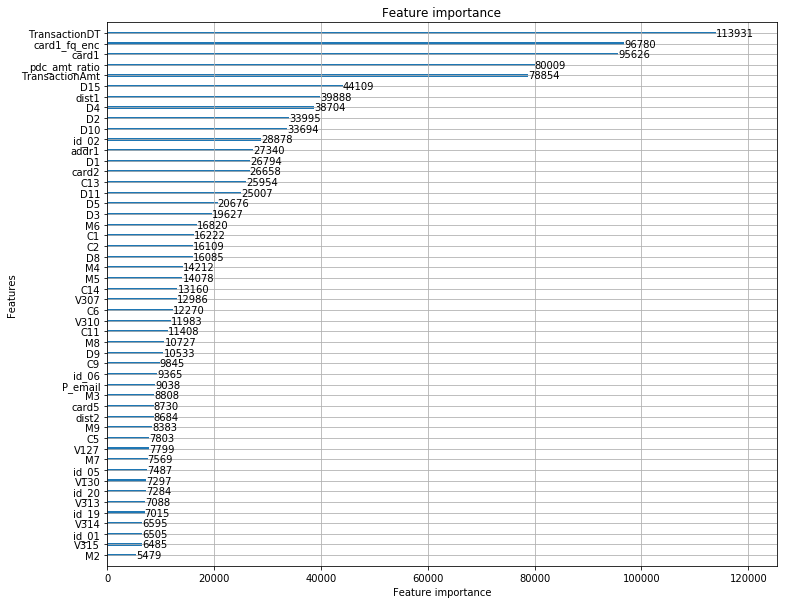

In [259]:
lgb.plot_importance(model, max_num_features=50,figsize=(12,10))

In [ ]:
fi_importance = permutation_importance(model,features_train.iloc[train_num:],
                                       labels_train.iloc[train_num:])

In [ ]:
fi_importance.sort_values(by='importance',ascending=False)[0:50]

,feature,importance
4,card2,0.019146
25,C13,0.011033
9,addr1,0.008327
13,C1,0.006357
23,C11,0.004418
429,P_email,0.004311
434,card1_fq_enc,0.003405
433,pdc_amt_ratio,0.002975
3,card1,0.002462
26,C14,0.002349


In [260]:
fi_importance.sort_values(by='importance',ascending=False)[-10:]

,feature,importance
366,V316,-0.000120
343,V293,-0.000121
360,V310,-0.000122
87,V37,-0.000133
329,V279,-0.000133
394,id_05,-0.000160
432,screen_height,-0.000185
357,V307,-0.000196
219,V169,-0.000199
31,D5,-0.000239


## Feature Test Result

In [375]:
features_train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,DeviceInfo,P_email,R_email,screen_width,pdc_amt_ratio,card1_fq_enc,addr1_fq_enc,P_email_fraud_rate,card4_fraud_rate,card_TAmt_ratio
2,86469,59.00,0,4663,490.0,150.0,2,166.0,1,330.0,...,-1,1,-1,-1,0.384085,1794,48387.0,0.097398,0.034756,0.398429
6,86522,159.00,0,12308,360.0,150.0,2,166.0,1,126.0,...,-1,2,-1,-1,1.035077,320,28198.0,0.022544,0.034756,1.073731
7,86529,422.50,0,12695,490.0,150.0,2,226.0,1,325.0,...,-1,3,-1,-1,2.750440,12732,76902.0,0.189624,0.034756,2.853153
12,86564,50.00,0,3786,418.0,150.0,2,226.0,1,204.0,...,-1,6,-1,-1,0.325496,403,77069.0,0.008133,0.034756,0.417284
24,86821,73.95,0,10112,360.0,150.0,2,166.0,1,264.0,...,-1,0,-1,-1,0.481408,6058,72580.0,0.043496,0.034756,0.787798


In [376]:
categorical = list(set(categorical_raw).intersection(features_train.columns))
ave_auc = fold_train_selector(3,features_train,labels_train,categorical)

Fold 0


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.98586	valid_1's auc: 0.902471
[1000]	training's auc: 0.997994	valid_1's auc: 0.911281
[1500]	training's auc: 0.999752	valid_1's auc: 0.912572
[2000]	training's auc: 0.999977	valid_1's auc: 0.912472
Early stopping, best iteration is:
[1568]	training's auc: 0.999817	valid_1's auc: 0.912678
  auc =  0.9126784150879194
Fold 1


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.986904	valid_1's auc: 0.924411
[1000]	training's auc: 0.998287	valid_1's auc: 0.931087
[1500]	training's auc: 0.999813	valid_1's auc: 0.931182
Early stopping, best iteration is:
[1182]	training's auc: 0.999217	valid_1's auc: 0.931517
  auc =  0.9315167787050482
Fold 2


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.986106	valid_1's auc: 0.915856
[1000]	training's auc: 0.998132	valid_1's auc: 0.920324
[1500]	training's auc: 0.999815	valid_1's auc: 0.920288
Early stopping, best iteration is:
[1374]	training's auc: 0.999655	valid_1's auc: 0.920518
  auc =  0.9205180788162458


In [377]:
# feat439 add card4_fraud_rate and card_TAmt_ratio
ave_auc

0.9215710908697379

In [366]:
# feat439 add card4_fraud_rate
ave_auc

0.921645405116515

In [342]:
# feat439 drop pemail and replace Remial with fraud rate
ave_auc

0.9213194526644399

In [323]:
# feat439 add pemail fraud rate
ave_auc

0.9214243953317114

In [301]:
# feat438 add addr1 cnt boost performance
ave_auc

0.9213639958310471

In [226]:
# feat437 add card1 cnt boost performance
ave_auc

0.9203949577672603

In [134]:
# feat436 add pdc_amt_std_ratio imporve but lower than pdc_amt_ratio
ave_auc

0.9192920643224514

In [126]:
# feat437 add pdc_amt_std_ratio-- lower performance
ave_auc

0.9190635954552597

In [118]:
# feat436 add pdc_amt_ratio-- very effective
ave_auc

0.9195010413382565

In [110]:
# feat435 clean id 33 if not treat as categorical performance drop
ave_auc

0.9183983651977423

In [105]:
# feat435 clean id 33 improve performance
ave_auc

0.9185938934394913

In [97]:
# feat453 clean DeviceInfo and modify Device_name
ave_auc

0.918457985563359

In [89]:
# feat435 clean DeviceInfo lead to even lower performance
ave_auc

0.9182738925634972

In [81]:
# feat435 clean id30 -- clean id_30 lead to lower performance
ave_auc

0.9184517740706151

In [73]:
# feat434 clean P and R email -- very effective
ave_auc

0.9185197763715043

In [65]:
# feat434 clean id31 -- very effective
ave_auc

0.9180120171424588

In [57]:
# feat434 without any change
ave_auc

0.9173765331946047

## Feature selection by Importance

In [324]:
#to_drop = list(select_by_importance(model,features_train,importance=0))
#to_drop = fi_importance[fi_importance.importance <0].feature
#to_drop = fi_importance.sort_values(by='importance',ascending=False)[-50:].feature
to_drop = ['P_email']

In [325]:
features_train_temp = features_train.drop(to_drop,axis=1)
categorical_temp = list(set(categorical_raw).intersection(features_train_temp.columns))
print(features_train_temp.head())
ave_auc = fold_train_selector(3,features_train_temp,labels_train,categorical_temp)

    TransactionDT  TransactionAmt  ProductCD  card1  card2  card3  card4  \
2           86469           59.00          0   4663  490.0  150.0      2   
6           86522          159.00          0  12308  360.0  150.0      2   
7           86529          422.50          0  12695  490.0  150.0      2   
12          86564           50.00          0   3786  418.0  150.0      2   
24          86821           73.95          0  10112  360.0  150.0      2   

    card5  card6  addr1  ...  id_36  id_38  DeviceType  DeviceInfo  R_email  \
2   166.0      1  330.0  ...     -1     -1          -1          -1       -1   
6   166.0      1  126.0  ...     -1     -1          -1          -1       -1   
7   226.0      1  325.0  ...     -1     -1          -1          -1       -1   
12  226.0      1  204.0  ...     -1     -1          -1          -1       -1   
24  166.0      1  264.0  ...     -1     -1          -1          -1       -1   

    screen_width  pdc_amt_ratio  card1_fq_enc  addr1_fq_enc  pemail_

/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.985424	valid_1's auc: 0.90215
[1000]	training's auc: 0.997865	valid_1's auc: 0.911577
[1500]	training's auc: 0.999707	valid_1's auc: 0.912857
[2000]	training's auc: 0.999969	valid_1's auc: 0.912869
Early stopping, best iteration is:
[1746]	training's auc: 0.999899	valid_1's auc: 0.913047
  auc =  0.9130468748681727
Fold 1


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.986443	valid_1's auc: 0.924333
[1000]	training's auc: 0.998188	valid_1's auc: 0.930901
[1500]	training's auc: 0.999777	valid_1's auc: 0.930559
Early stopping, best iteration is:
[1011]	training's auc: 0.998262	valid_1's auc: 0.93095
  auc =  0.9309502911237708
Fold 2


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.985675	valid_1's auc: 0.915235
[1000]	training's auc: 0.998009	valid_1's auc: 0.920488
Early stopping, best iteration is:
[968]	training's auc: 0.997724	valid_1's auc: 0.920499
  auc =  0.9204986529118921


In [326]:
# feat439 add pemail fraud rate drop pemail
ave_auc

0.9214986063012786

In [268]:
# # feat437 add card1 cnt drop fi_importance.sort_values(by='importance',ascending=False)[-50:].feature
ave_auc

0.9205252055310196

In [263]:
# feat437 add card1 cnt drop 'V169'
ave_auc

0.9204770443918444

In [258]:
# feat437 add card1 cnt drop 'D5'
ave_auc

0.9203641031040686

In [255]:
# feat437 add card1 cnt drop fi_importance[fi_importance.importance <0].feature
ave_auc

0.9206320242407664

In [252]:
# feat437 add card1 cnt drop fi_importance.sort_values(by='importance',ascending=False)[-100:].feature
ave_auc

0.9209194659248899

In [230]:
# feat437 add card1 cnt drop transactionDT
ave_auc

0.9210752136295715

In [269]:
to_drop = fi_importance.sort_values(by='importance',ascending=False)[-100:].feature
with open('./data/feat437_rm_pm_importance100.pickle', 'wb') as handle:
    pickle.dump(to_drop, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Recursive Eliminate Features

In [ ]:
# to_drop = {'P_email_suffix','R_email_suffix','dow','pdc_D1_ratio'} is useless
# to_drop = {'card_TAmt_ratio','card_TAmt_std_ratio','is_card_freq_pdc','is_card_freq_addr1'}is useless
# to_drop = {'TransactionAmt_decimal','is_wide','is_long','is_zero'} is useless
# to_drop = {'card_D2_mean','card_D15_mean','card_D4_mean','card_id_02_mean'','card_D1_std',
#            'card_D15_std','card_D1_mean','card_id_02_std','card_D3_mean} is useless
# to_drop = {'addr1_D15_mean','addr1_D15_std'} is useless
# to_drop = {'ProductCD_target_mean','M4_target_mean'} is useless
# to_drop = {'card2_fq_enc','card3_fq_enc','card5_fq_enc','P_email_fq_enc','R_email_fq_enc'} is useless
# to_drop = {'addr2_fq_enc',}
# to_drop = {'R_email_fraud_rate','card6_fraud_rate','card4_fraud_rate'} all have boost performance

In [399]:
features_train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,addr1_fq_enc,card_addr_fq,card_mv_hour_fq,card_mv_hour_fq_ratio,card_hour_Amt,card_hour_Amt_ratio,card_mv_day_fq,card_mv_day_fq_ratio,card_day_Amt,card_day_Amt_ratio
2,86469,59.00,0,4663,490.0,150.0,2,166.0,1,330.0,...,48387.0,13.0,1,1.000000,59.00,0.969659,1,1.000000,59.00,0.969659
6,86522,159.00,0,12308,360.0,150.0,2,166.0,1,126.0,...,28198.0,2.0,1,1.000000,159.00,1.338947,1,1.000000,159.00,1.338947
7,86529,422.50,0,12695,490.0,150.0,2,226.0,1,325.0,...,76902.0,221.0,1,0.909465,422.50,3.459943,2,0.975717,466.50,2.003035
12,86564,50.00,0,3786,418.0,150.0,2,226.0,1,204.0,...,77069.0,1.0,1,1.000000,50.00,1.000000,1,1.000000,50.00,1.000000
24,86821,73.95,0,10112,360.0,150.0,2,166.0,1,264.0,...,72580.0,1.0,1,1.000000,73.95,1.000000,1,1.000000,73.95,1.000000


In [400]:
best = 0.9213639958310471
to_drop = {'card_addr_fq','card_mv_hour_fq','card_mv_hour_fq_ratio',
           'card_hour_Amt','card_hour_Amt_ratio','card_mv_day_fq',
          'card_mv_day_fq_ratio','card_day_Amt','card_day_Amt_ratio'}
result = []
for col in to_drop:
    print(col)
    to_drop_temp = list(to_drop - set([col]))
    features_train_temp = features_train.drop(to_drop_temp,axis=1)
    print(features_train_temp.shape)
    categorical_temp = list(set(categorical_raw).intersection(features_train_temp.columns))
    ave_auc = fold_train_selector(3,features_train_temp,labels_train,categorical_temp)
    print(ave_auc)
    result.append([col,ave_auc])
        

card_mv_day_fq_ratio
(138771, 337)
Fold 0


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.986068	valid_1's auc: 0.900825
[1000]	training's auc: 0.998026	valid_1's auc: 0.909998
[1500]	training's auc: 0.999769	valid_1's auc: 0.911657
[2000]	training's auc: 0.999981	valid_1's auc: 0.911907
[2500]	training's auc: 0.999999	valid_1's auc: 0.911857
[3000]	training's auc: 1	valid_1's auc: 0.911914
Early stopping, best iteration is:
[2746]	training's auc: 1	valid_1's auc: 0.911995
  auc =  0.9119946029910482
Fold 1


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.986947	valid_1's auc: 0.924156
[1000]	training's auc: 0.998294	valid_1's auc: 0.93075
[1500]	training's auc: 0.99982	valid_1's auc: 0.930595
Early stopping, best iteration is:
[1081]	training's auc: 0.998793	valid_1's auc: 0.930865
  auc =  0.9308652884409228
Fold 2


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.986337	valid_1's auc: 0.915475
[1000]	training's auc: 0.998135	valid_1's auc: 0.920411
[1500]	training's auc: 0.999821	valid_1's auc: 0.920051
Early stopping, best iteration is:
[1069]	training's auc: 0.998621	valid_1's auc: 0.92045
  auc =  0.9204502237562597
0.9211033717294103
card_day_Amt
(138771, 337)
Fold 0


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.986187	valid_1's auc: 0.899942
[1000]	training's auc: 0.998065	valid_1's auc: 0.909762
[1500]	training's auc: 0.99978	valid_1's auc: 0.911401
[2000]	training's auc: 0.999982	valid_1's auc: 0.911642
[2500]	training's auc: 0.999999	valid_1's auc: 0.911852
[3000]	training's auc: 1	valid_1's auc: 0.912061
[3500]	training's auc: 1	valid_1's auc: 0.912133
Early stopping, best iteration is:
[3323]	training's auc: 1	valid_1's auc: 0.912186
  auc =  0.9121861256915874
Fold 1


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.98712	valid_1's auc: 0.924449
[1000]	training's auc: 0.99838	valid_1's auc: 0.930764
[1500]	training's auc: 0.999835	valid_1's auc: 0.930757
Early stopping, best iteration is:
[1128]	training's auc: 0.999077	valid_1's auc: 0.930897
  auc =  0.9308969688991491
Fold 2


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.986421	valid_1's auc: 0.915767
[1000]	training's auc: 0.998183	valid_1's auc: 0.920831
[1500]	training's auc: 0.999833	valid_1's auc: 0.920532
Early stopping, best iteration is:
[1009]	training's auc: 0.998251	valid_1's auc: 0.92086
  auc =  0.9208600806857759
0.9213143917588373
card_addr_fq
(138771, 337)
Fold 0


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.986255	valid_1's auc: 0.900813
[1000]	training's auc: 0.998046	valid_1's auc: 0.910248
[1500]	training's auc: 0.999759	valid_1's auc: 0.911527
[2000]	training's auc: 0.999976	valid_1's auc: 0.911719
[2500]	training's auc: 0.999998	valid_1's auc: 0.911751
[3000]	training's auc: 1	valid_1's auc: 0.912051
[3500]	training's auc: 1	valid_1's auc: 0.912046
[4000]	training's auc: 1	valid_1's auc: 0.911978
Early stopping, best iteration is:
[3716]	training's auc: 1	valid_1's auc: 0.912104
  auc =  0.9121041062679359
Fold 1


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.987111	valid_1's auc: 0.923574
[1000]	training's auc: 0.998311	valid_1's auc: 0.930428
[1500]	training's auc: 0.999806	valid_1's auc: 0.930217
Early stopping, best iteration is:
[1236]	training's auc: 0.999379	valid_1's auc: 0.930485
  auc =  0.930484545691811
Fold 2


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.98647	valid_1's auc: 0.915819
[1000]	training's auc: 0.998136	valid_1's auc: 0.920405
Early stopping, best iteration is:
[937]	training's auc: 0.997581	valid_1's auc: 0.920448
  auc =  0.9204480667287193
0.9210122395628222
card_mv_hour_fq_ratio
(138771, 337)
Fold 0


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.986013	valid_1's auc: 0.901107
[1000]	training's auc: 0.998017	valid_1's auc: 0.910373
[1500]	training's auc: 0.999761	valid_1's auc: 0.911843
[2000]	training's auc: 0.999977	valid_1's auc: 0.912103
Early stopping, best iteration is:
[1842]	training's auc: 0.99995	valid_1's auc: 0.912204
  auc =  0.9122035716415529
Fold 1


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.986908	valid_1's auc: 0.923775
[1000]	training's auc: 0.998276	valid_1's auc: 0.930779
[1500]	training's auc: 0.999811	valid_1's auc: 0.93068
Early stopping, best iteration is:
[1114]	training's auc: 0.998942	valid_1's auc: 0.930845
  auc =  0.9308452281356762
Fold 2


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.986295	valid_1's auc: 0.915678
[1000]	training's auc: 0.998115	valid_1's auc: 0.920747
Early stopping, best iteration is:
[992]	training's auc: 0.998052	valid_1's auc: 0.920821
  auc =  0.9208206846479906
0.9212898281417399
card_hour_Amt_ratio
(138771, 337)
Fold 0


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.986132	valid_1's auc: 0.900609
[1000]	training's auc: 0.998075	valid_1's auc: 0.909768
[1500]	training's auc: 0.999785	valid_1's auc: 0.91093
[2000]	training's auc: 0.999983	valid_1's auc: 0.911326
[2500]	training's auc: 0.999999	valid_1's auc: 0.911715
[3000]	training's auc: 1	valid_1's auc: 0.911762
[3500]	training's auc: 1	valid_1's auc: 0.911847
[4000]	training's auc: 1	valid_1's auc: 0.911916
Early stopping, best iteration is:
[3573]	training's auc: 1	valid_1's auc: 0.911897
  auc =  0.9118966562670039
Fold 1


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.987056	valid_1's auc: 0.92338
[1000]	training's auc: 0.998358	valid_1's auc: 0.929876
[1500]	training's auc: 0.999833	valid_1's auc: 0.930022
Early stopping, best iteration is:
[1218]	training's auc: 0.999372	valid_1's auc: 0.930112
  auc =  0.9301115667897668
Fold 2


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.9864	valid_1's auc: 0.915273
[1000]	training's auc: 0.998183	valid_1's auc: 0.920314
[1500]	training's auc: 0.999827	valid_1's auc: 0.919958
Early stopping, best iteration is:
[1146]	training's auc: 0.999046	valid_1's auc: 0.920403
  auc =  0.9204031615015663
0.920803794852779
card_mv_day_fq
(138771, 337)
Fold 0


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.986034	valid_1's auc: 0.901123
[1000]	training's auc: 0.997924	valid_1's auc: 0.910123
[1500]	training's auc: 0.999735	valid_1's auc: 0.911568
[2000]	training's auc: 0.999974	valid_1's auc: 0.911908
[2500]	training's auc: 0.999998	valid_1's auc: 0.912082
[3000]	training's auc: 1	valid_1's auc: 0.912176
[3500]	training's auc: 1	valid_1's auc: 0.912263
Early stopping, best iteration is:
[3315]	training's auc: 1	valid_1's auc: 0.912346
  auc =  0.9123458966808781
Fold 1


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.986893	valid_1's auc: 0.924394
[1000]	training's auc: 0.998239	valid_1's auc: 0.930873
[1500]	training's auc: 0.999799	valid_1's auc: 0.930797
Early stopping, best iteration is:
[1108]	training's auc: 0.998876	valid_1's auc: 0.930953
  auc =  0.9309525215646572
Fold 2


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.986308	valid_1's auc: 0.915815
[1000]	training's auc: 0.998065	valid_1's auc: 0.921312
Early stopping, best iteration is:
[973]	training's auc: 0.997841	valid_1's auc: 0.92136
  auc =  0.9213602832583254
0.921552900501287
card_hour_Amt
(138771, 337)
Fold 0


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.986041	valid_1's auc: 0.900688
[1000]	training's auc: 0.998004	valid_1's auc: 0.909947
[1500]	training's auc: 0.999763	valid_1's auc: 0.911673
[2000]	training's auc: 0.99998	valid_1's auc: 0.911914
[2500]	training's auc: 0.999999	valid_1's auc: 0.912031
Early stopping, best iteration is:
[2392]	training's auc: 0.999998	valid_1's auc: 0.912123
  auc =  0.9121227457365354
Fold 1


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.986887	valid_1's auc: 0.923916
[1000]	training's auc: 0.998316	valid_1's auc: 0.9309
[1500]	training's auc: 0.999822	valid_1's auc: 0.930641
Early stopping, best iteration is:
[1011]	training's auc: 0.998395	valid_1's auc: 0.930946
  auc =  0.9309463118532768
Fold 2


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.986364	valid_1's auc: 0.915607
[1000]	training's auc: 0.99814	valid_1's auc: 0.920923
[1500]	training's auc: 0.999818	valid_1's auc: 0.920365
Early stopping, best iteration is:
[1007]	training's auc: 0.998194	valid_1's auc: 0.920951
  auc =  0.9209514442722335
0.9213401672873485
card_day_Amt_ratio
(138771, 337)
Fold 0


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.986131	valid_1's auc: 0.899886
[1000]	training's auc: 0.998071	valid_1's auc: 0.90923
[1500]	training's auc: 0.999784	valid_1's auc: 0.910234
[2000]	training's auc: 0.999984	valid_1's auc: 0.910408
Early stopping, best iteration is:
[1581]	training's auc: 0.999853	valid_1's auc: 0.910464
  auc =  0.9104639976544477
Fold 1


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.987103	valid_1's auc: 0.92377
[1000]	training's auc: 0.998364	valid_1's auc: 0.930274
[1500]	training's auc: 0.999831	valid_1's auc: 0.930524
Early stopping, best iteration is:
[1403]	training's auc: 0.999729	valid_1's auc: 0.930655
  auc =  0.9306550190060547
Fold 2


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.986424	valid_1's auc: 0.91571
[1000]	training's auc: 0.998191	valid_1's auc: 0.92061
Early stopping, best iteration is:
[896]	training's auc: 0.997174	valid_1's auc: 0.920716
  auc =  0.9207163644317304
0.920611793697411
card_mv_hour_fq
(138771, 337)
Fold 0


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.985909	valid_1's auc: 0.900941
[1000]	training's auc: 0.997879	valid_1's auc: 0.910224
[1500]	training's auc: 0.999721	valid_1's auc: 0.911763
[2000]	training's auc: 0.999971	valid_1's auc: 0.911937
[2500]	training's auc: 0.999998	valid_1's auc: 0.912016
[3000]	training's auc: 1	valid_1's auc: 0.912258
[3500]	training's auc: 1	valid_1's auc: 0.912381
[4000]	training's auc: 1	valid_1's auc: 0.912425
[4500]	training's auc: 1	valid_1's auc: 0.912487
Early stopping, best iteration is:
[4013]	training's auc: 1	valid_1's auc: 0.912414
  auc =  0.9124139848611627
Fold 1


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.986727	valid_1's auc: 0.923832
[1000]	training's auc: 0.998193	valid_1's auc: 0.930643
[1500]	training's auc: 0.999789	valid_1's auc: 0.930649
Early stopping, best iteration is:
[1393]	training's auc: 0.999655	valid_1's auc: 0.93077
  auc =  0.930769857678402
Fold 2


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.986218	valid_1's auc: 0.915864
[1000]	training's auc: 0.998021	valid_1's auc: 0.920912
Early stopping, best iteration is:
[995]	training's auc: 0.997978	valid_1's auc: 0.920963
  auc =  0.9209625422060498
0.9213821282485382


In [401]:
result
best = 0.9213639958310471

[['card_mv_day_fq_ratio', 0.9211033717294103],
 ['card_day_Amt', 0.9213143917588373],
 ['card_addr_fq', 0.9210122395628222],
 ['card_mv_hour_fq_ratio', 0.9212898281417399],
 ['card_hour_Amt_ratio', 0.920803794852779],
 ['card_mv_day_fq', 0.921552900501287],
 ['card_hour_Amt', 0.9213401672873485],
 ['card_day_Amt_ratio', 0.920611793697411],
 ['card_mv_hour_fq', 0.9213821282485382]]

In [389]:
result
0.921645405116515

[['card6_fraud_rate', 0.9214416558805145],
 ['card_TAmt_ratio', 0.9214050655534516],
 ['card_pdc_cnt', 0.9213649170829448],
 ['hour_Amt', 0.9218786982153215],
 ['R_email_fraud_rate', 0.921679151177818],
 ['card_hour_fq', 0.9216196951784377]]

In [354]:
result

[['R_email_fraud_rate', 0.921574223298346],
 ['card4_fraud_rate', 0.921645405116515],
 ['card6_fraud_rate', 0.9215957937687596]]